In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from tqdm.auto import tqdm

data_dir = '../data/hateful_memes'
img_dir = os.path.join(data_dir, 'img')

In [2]:
print(len(os.listdir(img_dir)))

FileNotFoundError: [WinError 3] 系统找不到指定的路径。: '../data/hateful_memes\\img'

In [3]:
splits = ['train', 'dev_seen', 'test_seen']
df = []
for split in splits:
    file_path = os.path.join(data_dir, f'{split}.jsonl')
    split_df = pd.read_json(file_path, lines=True)
    split_df['split'] = split
    df.append(split_df)

df = pd.concat(df, axis=0, ignore_index=True)
df['id'] = df['img'].str.split('/').str[1].str.split('.').str[0]
df.index = df['id']
df.index.name = None
print(df.shape)
df.head()


ValueError: Expected object or value

In [4]:
df['split'].value_counts()

TypeError: list indices must be integers or slices, not str

In [5]:
#df = df[df['split']=='train']

In [6]:
df['label'].value_counts(normalize=False)

TypeError: list indices must be integers or slices, not str

In [7]:
df['text'].nunique()

TypeError: list indices must be integers or slices, not str

# Match Images based on Text

In [8]:
idx_to_text = {idx:text for idx, text in enumerate(df['text'].unique())}
text_to_idx = {v:k for k, v in idx_to_text.items()}

TypeError: list indices must be integers or slices, not str

In [9]:
df['text_idx'] = df['text'].map(text_to_idx)
df.head()

,id,img,label,text,split,text_idx
42953,42953,img/42953.png,0,its their character not their color that matters,train,0
23058,23058,img/23058.png,0,don't be afraid to love again everyone is not ...,train,1
13894,13894,img/13894.png,0,putting bows on your pet,train,2
37408,37408,img/37408.png,0,i love everything and everybody! except for sq...,train,3
82403,82403,img/82403.png,0,"everybody loves chocolate chip cookies, even h...",train,4


In [9]:
df['text_idx'].value_counts()[:100].plot.bar(figsize=(30,5))

TypeError: list indices must be integers or slices, not str

In [10]:
df['text_idx'].value_counts().value_counts()

TypeError: list indices must be integers or slices, not str

In [11]:
# {text_id: [meme_idx_1, ...], ...}
text_idx_to_memes = df.groupby('text_idx')['id'].apply(list).to_dict()
text_idx_to_memes = {k:v for k, v in text_idx_to_memes.items() if len(v) > 1}
print(len(text_idx_to_memes))

AttributeError: 'list' object has no attribute 'groupby'

In [13]:
text_idx_to_label_to_memes = {}
for text_idx, memes in text_idx_to_memes.items():
    text_idx_to_label_to_memes[text_idx] = {}
    text_idx_to_label_to_memes[text_idx]['non-hateful'] = []
    text_idx_to_label_to_memes[text_idx]['hateful'] = []

    hateful_added, non_hateful_added = False, False
    for meme_idx in memes:
        if df.loc[meme_idx]['label'] == 0:
            text_idx_to_label_to_memes[text_idx]['non-hateful'].append(meme_idx)
            non_hateful_added = True
        else:
            text_idx_to_label_to_memes[text_idx]['hateful'].append(meme_idx)
            hateful_added = True

    if not hateful_added or not non_hateful_added:
        del text_idx_to_label_to_memes[text_idx]

    # if len(text_idx_to_label_to_memes[text_idx]['non-hateful']) == 0:
    #     del text_idx_to_label_to_memes[text_idx]['non-hateful']
    # if len(text_idx_to_label_to_memes[text_idx]['hateful']) == 0:
    #     del text_idx_to_label_to_memes[text_idx]['hateful']

print(len(text_idx_to_label_to_memes))

1043


In [12]:
list(text_idx_to_label_to_memes.items())[:10]

NameError: name 'text_idx_to_label_to_memes' is not defined

In [13]:
df.loc['07481']

AttributeError: 'list' object has no attribute 'loc'

In [14]:
sample_text_idx = np.random.choice(list(text_idx_to_label_to_memes.keys()))
print(text_idx_to_label_to_memes[sample_text_idx])
meme_idx_1 = np.random.choice(text_idx_to_label_to_memes[sample_text_idx]['non-hateful'])
meme_idx_2 = np.random.choice(text_idx_to_label_to_memes[sample_text_idx]['hateful'])

fig, axes = plt.subplots(1, 2, figsize=(15,10))
axes[0].imshow(Image.open(f'{img_dir}/{meme_idx_1}.png'))
axes[1].imshow(Image.open(f'{img_dir}/{meme_idx_2}.png'))
axes[0].set_title(f'{meme_idx_1}: non-hateful')
axes[1].set_title(f'{meme_idx_2}: hateful')
plt.show()

NameError: name 'text_idx_to_label_to_memes' is not defined

# Grouping similar sentences

In [15]:
import spacy
from multiprocessing import Pool

nlp = spacy.load("en_core_web_md")

from sentence_transformers import SentenceTransformer
model = SentenceTransformer('distilbert-base-nli-mean-tokens')

ModuleNotFoundError: No module named 'spacy'

In [16]:
def get_simlarity(text1, text2, method='spacy'):
    """
    src: https://stackoverflow.com/questions/65199011/is-there-a-way-to-check-similarity-between-two-full-sentences-in-python
    """

    if method == 'jaccard':
        text1 = set(text1.lower().split(" "))
        text2 = set(text2.lower().split(" "))
        score = len(text1.intersection(text2)) / len(text1.union(text2))
    elif method == 'spacy':
        embed1 = nlp(text1)
        embed2 = nlp(text2)
        score = embed1.similarity(embed2)
    else:
        raise ValueError

    return score

In [17]:
meme_idx_to_text = df['text'].to_dict()
meme_idxs = list(meme_idx_to_text.keys())
scores = np.zeros((len(meme_idxs), len(meme_idxs)))

for i in tqdm(range(len(meme_idxs))):
    for j in range(i+1, len(meme_idxs)):
        text_i = meme_idx_to_text[meme_idxs[i]]
        text_j = meme_idx_to_text[meme_idxs[j]]
        score = get_simlarity(text_i, text_j, method='jaccard')
        scores[i, j] = score
        scores[j, i] = score

# with Pool(2) as pool:
#     pool.map(compute_similarity, range(len(text_idxs)))
#     # for _ in tqdm(pool.imap_unordered(compute_similarity, text_ids), total=len(text_ids)):
#     #     pass

TypeError: list indices must be integers or slices, not str

In [18]:
sentences = list(meme_idx_to_text.values())
sentence_embeddings = model.encode(sentences)
print(sentence_embeddings.shape, type(sentence_embeddings))

NameError: name 'meme_idx_to_text' is not defined

In [19]:
from sklearn.metrics.pairwise import cosine_distances, cosine_similarity
scores_tr = cosine_similarity(sentence_embeddings)
for i in range(len(scores_tr)):
    scores_tr[i, i] = 0
print(scores_tr.shape)
print(scores_tr.min(), scores_tr.max())

NameError: name 'sentence_embeddings' is not defined

In [ ]:
i_idxs, j_idxs = np.where((scores>0.7) & (scores_tr>0.7))
print(len(i_idxs))
for i, j in zip(i_idxs[:5], j_idxs[:5]):
    print(meme_idxs[i], meme_idxs[j],  f'jaccard: {scores[i, j]}; tr: {scores_tr[i, j]}')
    print(meme_idx_to_text[meme_idxs[i]], '\n', meme_idx_to_text[meme_idxs[j]], '\n')
    

In [20]:
meme_idxs = list(meme_idx_to_text.keys())
psuedo_text_idx_to_meme_idxs = {}
for i, j in zip(i_idxs, j_idxs):
    for k in range(len(psuedo_text_idx_to_meme_idxs)):
        if meme_idxs[i] in psuedo_text_idx_to_meme_idxs[k] or meme_idxs[j] in psuedo_text_idx_to_meme_idxs[k]:
            psuedo_text_idx_to_meme_idxs[k].update({meme_idxs[i], meme_idxs[j]})
            break
    else:
        psuedo_text_idx_to_meme_idxs[len(psuedo_text_idx_to_meme_idxs)] = {meme_idxs[i], meme_idxs[j]}
print(len(psuedo_text_idx_to_meme_idxs))

NameError: name 'meme_idx_to_text' is not defined

In [21]:
#psuedo_text_idx_to_meme_idxs

In [22]:
meme_idx_to_psuedo_text_idx = {}
for psuedo_text_idx, meme_idxs in psuedo_text_idx_to_meme_idxs.items():
    for meme_idx in meme_idxs:
        meme_idx_to_psuedo_text_idx[meme_idx] = psuedo_text_idx
print(len(meme_idx_to_psuedo_text_idx))

# for meme idxs that are not covered
non_covered_meme_idxs = set(df['id'].values) - set(meme_idx_to_psuedo_text_idx.keys())
for i, non_covered_meme_idx in enumerate(non_covered_meme_idxs, start=len(psuedo_text_idx_to_meme_idxs)):
    meme_idx_to_psuedo_text_idx[non_covered_meme_idx] = i
print(len(meme_idx_to_psuedo_text_idx))

NameError: name 'psuedo_text_idx_to_meme_idxs' is not defined

In [23]:
df['pseudo_text_idx'] = df['id'].map(meme_idx_to_psuedo_text_idx)

TypeError: list indices must be integers or slices, not str

In [24]:
df.describe()

AttributeError: 'list' object has no attribute 'describe'

In [25]:
df.head()

AttributeError: 'list' object has no attribute 'head'

# Find Image index

In [26]:
from skimage.metrics import structural_similarity as compare_ssim
import imutils
import cv2

ModuleNotFoundError: No module named 'skimage'

In [27]:
#imgs = [cv2.resize(cv2.imread(f'{data_dir}/{img_fp}', 0), (128, 128)) for img_fp in df['img'].values]
#len(imgs)

In [28]:
#plt.imshow(imgs[2], cmap='gray')

In [29]:
# scores_ssim = np.zeros((len(imgs), len(imgs)))
# for i in tqdm(range(len(imgs))):
#     for j in range(i+1, len(imgs)):
#         (score, diff) = compare_ssim(imgs[i], imgs[j], full=True)
#         scores_ssim[i, j] = score

In [30]:
import torch
from torchvision.models import resnet18 

model = resnet18(pretrained=True)
model.eval()
feature_extractor = torch.nn.Sequential(*list(model.children())[:-1])
x = torch.randn([1,3,224,224])
output = feature_extractor(x) 
print(output.shape)

ModuleNotFoundError: No module named 'torchvision'

In [ ]:
from PIL import Image
import torchvision.transforms as T

transforms = T.Compose([T.Resize(224), T.ToTensor(), T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

imgs = []
for img_fp in tqdm(df['img'].values.tolist()):
    img = Image.open(f'{data_dir}/{img_fp}').convert('RGB').resize((224, 224))
    img = transforms(img).unsqueeze(dim=0)
    imgs.append(img)


In [31]:
imgs = torch.cat(imgs, dim=0)
print(imgs.shape)

NameError: name 'imgs' is not defined

In [36]:
batch_size = 100
assert len(imgs) % batch_size == 0
num_batches = len(imgs) // batch_size
imgs_features = []
for i in tqdm(range(num_batches)):
    start_idx = i*batch_size
    end_idx = start_idx + batch_size
    imgs_features_batch = feature_extractor(imgs[start_idx:end_idx])
    imgs_features_batch = imgs_features_batch.squeeze().detach().numpy()
    imgs_features.append(imgs_features_batch)
imgs_features = np.concatenate(imgs_features)
print(imgs_features.shape)

  0%|          | 0/100 [00:00<?, ?it/s]

(10000, 512)


In [37]:
from sklearn.metrics.pairwise import cosine_distances, cosine_similarity
scores_img = cosine_similarity(imgs_features)
for i in range(len(scores_img)):
    scores_img[i, i] = 0
print(scores_img.shape)
print(scores_img.min(), scores_img.max())

(10000, 10000)
0.0 0.99947596


14556
42953 51683 scores_img: 0.9826446771621704


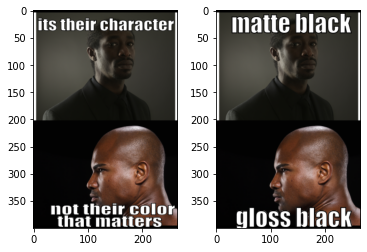

82403 71038 scores_img: 0.923524022102356


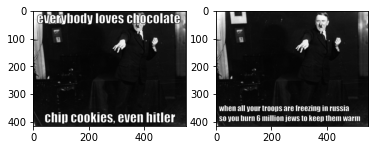

16952 92738 scores_img: 0.94631427526474


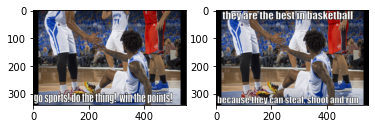

In [38]:
i_idxs, j_idxs = np.where((scores_img>0.92) & (scores_img<1))
print(len(i_idxs))
meme_idx_to_img = df['img'].to_dict()
meme_idxs = list(meme_idx_to_img.keys())
for i, j in zip(i_idxs[:3], j_idxs[:3]):
    print(meme_idxs[i], meme_idxs[j],  f'scores_img: {scores_img[i, j]}')
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(Image.open(f'{data_dir}/{meme_idx_to_img[meme_idxs[i]]}'))
    axes[1].imshow(Image.open(f'{data_dir}/{meme_idx_to_img[meme_idxs[j]]}'))
    plt.show()
    
    

In [39]:
meme_idxs = list(meme_idx_to_img.keys())
psuedo_img_idx_to_meme_idxs = {}
for i, j in zip(i_idxs, j_idxs):
    for k in range(len(psuedo_img_idx_to_meme_idxs)):
        if meme_idxs[i] in psuedo_img_idx_to_meme_idxs[k] or meme_idxs[j] in psuedo_img_idx_to_meme_idxs[k]:
            psuedo_img_idx_to_meme_idxs[k].update({meme_idxs[i], meme_idxs[j]})
            break
    else:
        psuedo_img_idx_to_meme_idxs[len(psuedo_img_idx_to_meme_idxs)] = {meme_idxs[i], meme_idxs[j]}
print(len(psuedo_img_idx_to_meme_idxs))

1641


In [40]:
#psuedo_img_idx_to_meme_idxs

In [41]:
meme_idx_to_psuedo_img_idx = {}
for psuedo_img_idx, meme_idxs in psuedo_img_idx_to_meme_idxs.items():
    for meme_idx in meme_idxs:
        meme_idx_to_psuedo_img_idx[meme_idx] = psuedo_img_idx
print(len(meme_idx_to_psuedo_img_idx))

# for meme idxs that are not covered
non_covered_meme_idxs = set(df['id'].values) - set(meme_idx_to_psuedo_img_idx.keys())
for i, non_covered_meme_idx in enumerate(non_covered_meme_idxs, start=len(psuedo_img_idx_to_meme_idxs)):
    meme_idx_to_psuedo_img_idx[non_covered_meme_idx] = i
print(len(meme_idx_to_psuedo_img_idx))

4289
10000


In [42]:
df['pseudo_img_idx'] = df['id'].map(meme_idx_to_psuedo_img_idx)

In [43]:
df.head()

,id,img,label,text,split,text_idx,pseudo_text_idx,pseudo_img_idx
42953,42953,img/42953.png,0,its their character not their color that matters,train,0,4901,0
23058,23058,img/23058.png,0,don't be afraid to love again everyone is not ...,train,1,3620,3486
13894,13894,img/13894.png,0,putting bows on your pet,train,2,0,3956
37408,37408,img/37408.png,0,i love everything and everybody! except for sq...,train,3,4451,4313
82403,82403,img/82403.png,0,"everybody loves chocolate chip cookies, even h...",train,4,5609,1


In [44]:
df.nunique()

id                 10000
img                10000
label                  2
text                8045
split                  3
text_idx            8045
pseudo_text_idx     7499
pseudo_img_idx      7352
dtype: int64

In [32]:
file_path = f'{data_dir}/info.csv'
df.to_csv(file_path, index=False)

AttributeError: 'list' object has no attribute 'to_csv'